[View in Colaboratory](https://colab.research.google.com/github/eveem/practice/blob/master/app_word2vec_v1.ipynb)

### Install and import packages 

In [1]:
!pip install xlrd
!pip install pandas
!pip install -U -q PyDrive
!pip install sklearn_crfsuite
!pip install gensim
!pip install networkx

import pandas as pd
import xlrd
import zipfile, os
import pickle
import re
import gensim
import matplotlib.pyplot as plt
import networkx as nx
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

    100% |████████████████████████████████| 112kB 4.4MB/s 
    100% |████████████████████████████████| 747kB 8.4MB/s 
    100% |████████████████████████████████| 51kB 16.7MB/s 
    100% |████████████████████████████████| 51kB 17.4MB/s 
  Running setup.py bdist_wheel for tabulate ... - \ done
  Stored in directory: /content/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built tabulate
    100% |████████████████████████████████| 22.6MB 1.8MB/s 
    100% |████████████████████████████████| 1.4MB 14.9MB/s 


    100% |████████████████████████████████| 133kB 23.8MB/s 
    100% |████████████████████████████████| 61kB 19.5MB/s 
    100% |████████████████████████████████| 4.4MB 5.0MB/s 
    100% |████████████████████████████████| 552kB 23.6MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b1/9e/7d/bb3d3b55c597e72617140a0638c06382a5f17283881eae163e
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


### Define function

In [2]:
def upload_xlsx ():
  uploaded = files.upload()
  for i in uploaded:
    file_name = i
    return file_name

def create_csv ():
  file_name = upload_xlsx()
  xls = pd.ExcelFile(file_name, on_demand = True)
  sheets = xls.sheet_names
  print('Sheet name list : ', end='')
  print(sheets)
  while True:
    sheet_name = input('Enter sheet name : ')
    if sheet_name in sheets:
      break
    else:
      print('Error!! Do not have this sheet name..')

  df = pd.read_excel(file_name, sheetname=sheet_name, index_col=None)
  df.to_csv('csvfile.csv', encoding='utf-8', index=False)
  print('Create CSV file complete...')
  
def create_text_list ():
  df = pd.read_csv('csvfile.csv')
  print('Field name list : ', end='')
  fields = df.columns.values
  print(fields)
  while True:
    field_name = input('Enter field name : ')
    if field_name in fields:
      break
    else:
      print('Error!! Do not have this field name..')

  text_list = [i for i in df[field_name] if i]
  print('Create list of text complete...')
  return text_list

def sent2labels(sent):
  return [label for cur, tag in sent]

def sent2features(sent):
  data = []
  for cur, tag in sent:
    data.append({'current': cur, 'tag': tag})
  return data

def generate_feature (text_list):
  tag_type = ['c', 'n', 'v', 'w', 't', 's', 'd']
  rex_thai = re.compile(r"[^\u0E00-\u0E7F' ]|^'|'$|''")
  c_tag = set('กขฃคฆงจชซญฎฏฐฑฒณดตถทธนบปพฟภมยรลวศษสฬอ')
  n_tag = set('ฅฉผฝฌหฮ')
  v_tag = {'ะ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'า', 'ำ', 'ๅ', '็', 'ั'}
  w_tag = {'เ', 'แ', 'โ', 'ใ', 'ไ'}
  t_tag = {'่',  '้', '๊', '๋'}
  s_tag = {'ฺ', '์', 'ๆ', 'ฯ'}
  d_tag = set('0123456789')
  
  new_text = []
  for line in text_list:
    char_to_remove = re.findall(rex_thai, line)
    list_with_char_removed = [char for char in line if not char in char_to_remove]
    line = ''.join(list_with_char_removed)
    temp = line
    if ' ' in line:
      temp = temp.replace(' ', '')
    new_text.append(temp)  
    
  raw_data = []
  for line in new_text:
    len_line = len(line)
    d = []
    for i in range(0, len_line):
      t = ''
      for tag in tag_type:
        if line[i] in vars()[tag + '_tag']:
          t = tag
      d.append((line[i], t))
    raw_data.append(d)
  print('Create list of char and feature complete...')
  return raw_data

def download_model ():
  # change by url
  zip_id = '1WwyyzOS7rsDGTSnxCkEBXaLqGBmGUHA4'
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Downloading zip file
  myzip = drive.CreateFile({'id': zip_id})
  myzip.GetContentFile('model.zip')

  # Uncompressing zip file
  zip_ref = zipfile.ZipFile('model.zip', 'r')
  zip_ref.extractall('MODEL/')
  
  with open('./MODEL/model.pickle', 'rb') as handle:
    crf_model = pickle.load(handle)

  print('Download model complete...')
  return crf_model

def tokenize (model, x_data):
  x_data = [sent2features(s) for s in x_data]
  y_data = model.predict(x_data)
  splited_list = []
  len_text = len(x_data)
  
  for i in range(0, len_text):
    len_line = len(x_data[i])
    split_by_pipe = ''
    if len_line > 1:
      for j in range(0, len_line):
        if y_data[i][j] == 'B' and j != 0:
          split_by_pipe += '|'
        split_by_pipe += x_data[i][j]['current']
      splited_list.append(split_by_pipe)
  return splited_list

def generate_word2vec (pipe_list):
  documents = []
  dict_count = dict()
  
  for i in pipe_list:
    temp = i.split('|')
    documents.append(temp)
    for word in temp:
      if word in dict_count:
        dict_count[word] += 1
      else:
        dict_count[word] = 1
  
  print('Generate list of text split by pipe complete...')
  
  model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
  model.train(documents, total_examples=len(documents), epochs=10)
  
  print('Generate word2vec complete...')
  import operator
  dc_sort = sorted(dict_count.items(),key = operator.itemgetter(1), reverse = True)
  top_word = dc_sort[0:10]

  print('Show word list and graph...')
  
  for i in top_word:
    G = nx.Graph()
    w = i[0]
    print(w + '[A' + ']' + ' : ', end='')
    near = model.wv.most_similar(positive=w, topn=10)
    ed = 'B'
    for word in near:
      nowed = chr(ord(ed) + near.index(word))
      print(word[0] + ' [' + nowed + ']' + ', ', end='')
      G.add_edge('A', nowed, weight=1/word[1])
    print('\n')
    pos = nx.spring_layout(G) 
    elist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0]
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=elist, width=6)
    nx.draw_networkx_labels(G, pos)
    plt.axis('off')
    plt.show()
  return 0

def run_program ():
  create_csv()
  text_list = create_text_list()
  char_with_feature = generate_feature(text_list)
  crf_model = download_model()
  pipe_split_list = tokenize(crf_model, char_with_feature)
  doc = generate_word2vec(pipe_split_list)

### Run

* upload file .xlsx 
* enter **sheet name** 
* enter **field name**
* and.. wait



Download model complete...
Generate list of text split by pipe complete...
Generate word2vec complete...
Show word list and graph...
ฟิล[A] : เย็น [B], ฟฟ [C], 



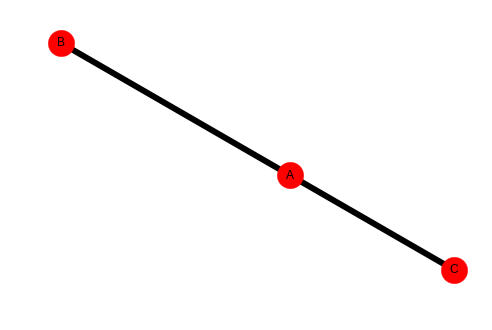

เย็น[A] : ฟฟ [B], ฟิล [C], 



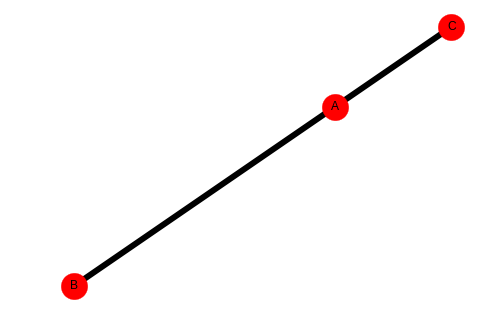

ฟฟ[A] : เย็น [B], ฟิล [C], 



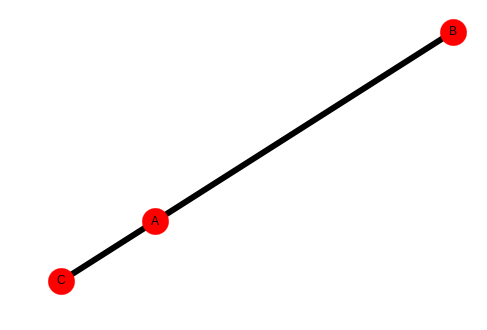

เตอร์ยี่[A] : 

KeyError: ignored

In [4]:
run_program ()